<a href="https://colab.research.google.com/github/hugeclear/image_recognition/blob/master/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第1章 画像分類

* vggモデルを使ったfine-tuningの実装

フォルダの準備

In [ ]:
import os
import urllib.request
import zipfile

In [ ]:
data_dir = "./data/"
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

In [ ]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)


In [ ]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去

必要ライブラリのインストール

In [ ]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

versioin confirm

In [ ]:
print("pytorch version: ",torch.__version__)
print("torchvision version: ",torchvision.__version__)

pytorch version:  1.12.0+cu113
torchvision version:  0.13.0+cu113


# vgg16の学習済みモデルをダウンロード

In [ ]:
use_pretrained=True
net = models.vgg16(pretrained=use_pretrained)
net.eval () #推論モードに設定
print(net)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

学習済みモデルをロードすることができたので、続いて、モデルに画像を入力できるようにするために、画像の前処理を行う必要がある
# 前処理とは、画像のリサイズと式情報の規格化
規格化＝ｒｇｂに対して、平均が（0.485,0.456,0.406)、標準偏差が(0.229,0.224,0.225)の条件で標準b化を行う、この条件はダウンロードしたモデルと同じ条件で前処理を行うため

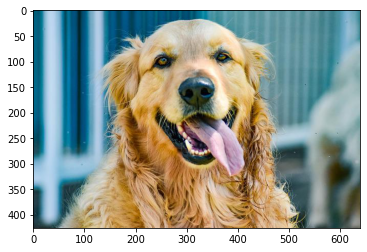

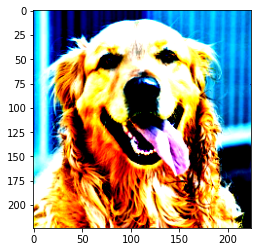

In [ ]:
class BaseTransform():
  def __init__(self,resize,mean,std):
    self.base_transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)#標準化
    ])
  def __call__(self, img):
    return self.base_transform(img)
    
#check process operation
image_file_path = '/content/data/goldenretriever-g0b331a34b_640.jpg'
img = Image.open(image_file_path)#read image

plt.imshow(img)
plt.show()

resize = 224
mean=(0.485,0.456,0.406)#平均値
std= (0.229,0.224,0.225)#標準偏差
transform = BaseTransform(resize,mean,std)
img_transformed = transform(img) #torchsize ([3,224,224])

#difference order of images so setting 
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()

    

# 出力結果からラベルを予測する後処理クラスを作成

In [ ]:
ILSVRC_class_index = json.load(open('/content/data/imagenet_class_index.json','r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [ ]:
class ILSVRCPredictor():
  """
  class_index : dictionary
  クラスindexとラベル名を対応させた辞書型変数。
  """
  def __init__(self,class_index):
    self.class_index=class_index
  def predict_max(self,out):
    maxid = np.argmax(out.detach().numpy())
    predicted_label_name = self.class_index[str(maxid)][1]

    return predicted_label_name


In [ ]:
ILSVRC_class_index = json.load(open('/content/data/imagenet_class_index.json','r'))

predictor = ILSVRCPredictor(ILSVRC_class_index)

iamge_file_path = '/content/data/goldenretriever-g0b331a34b_640.jpg'
img = Image.open(image_file_path)
transform = BaseTransform(resize,mean,std)
img_transformed = transform(img)
inputs=img_transformed.unsqueeze_(0)

out = net(inputs)
result = predictor.predict_max(out)
print("result of input image: ",result)


result of input image:  golden_retriever
